In [1]:
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math

import snntorch as snn
import torch
import torch.nn as nn

import snntorch.spikeplot as splt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from snntorch import surrogate
import snntorch.functional as SF
import torch.nn.functional as F

from snntorch import spikegen

import matplotlib.pyplot as plt
import snntorch.spikeplot as splt

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


/home/andrea/anaconda3/envs/torch/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449229234/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
num_events = 100000
num_events_test = 10000
num_events_val = 10000
events_arr, muon_list, max_n = ge.generate_noisy_evts(num_events, noise_frac=0.4, bkg_frac=0.5)
events_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(num_events_test, noise_frac=0.4, bkg_frac=0.5)
events_arr_val, muon_list_val, max_n_val = ge.generate_noisy_evts(num_events_val, noise_frac=0.4, bkg_frac=0.5)

100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 937.67it/s]


In [4]:
def get_data(muon_list):
    data = np.zeros(shape=(len(muon_list), 1,ps.NLAYERS, ps.NWIRES), dtype=np.float32)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1
            
            data[i, 0,layer, wire] = 1

    return data

def get_target(muon_list):
    target = np.zeros(shape=(len(muon_list), 1,ps.NLAYERS, ps.NWIRES), dtype=np.float32)
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, 0,layer, wire] = 1

    return target

# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype=np.int16,
               features=['layer', 'wire_num', 'bx', 't0']):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return padded_array

In [5]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, window):
        
        self.data = input_data
        self.labels = target
        self.window = window

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': torch.tensor(self.data[idx],dtype=torch.float32), 
                  'label': torch.tensor(self.labels[idx],dtype=torch.float32),
                  "window":torch.tensor(self.window[idx],dtype=torch.float32)}  
        return sample

In [6]:
feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']

window = get_data(muon_list)
target = get_target(muon_list)

window_test= get_data(muon_list_test)
target_test = get_target(muon_list_test)

window_val = get_data(muon_list_val)
target_val = get_target(muon_list_val)


muon_array = convert_to(muon_list, size=max_n, target_dtype=np.float32,
                        features=feature_list)

muon_array_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32,
                        features=feature_list)

muon_array_val = convert_to(muon_list_val, size=max_n_val, target_dtype=np.float32,
                        features=feature_list)

100000it [00:00, 509615.53it/s]
100000it [00:00, 727805.03it/s]
10000it [00:00, 609770.15it/s]
10000it [00:00, 660301.95it/s]
10000it [00:00, 493970.56it/s]
10000it [00:00, 513737.12it/s]


In [7]:
train_dataset = CustomDataset(muon_array,target,window)
test_dataset  = CustomDataset(muon_array_test,target_test,window_test)
val_dataset   = CustomDataset(muon_array_val,target_val,window_val)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

## SpikeGen

In [8]:
def custom_spikegen(data,reference, num_step=40):
    
    ref = reference.squeeze()
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    
    for n_batch, evt in enumerate(data):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            layer = int(hit[0])
            wire = int(hit[1])
            
            if ref[n_batch][layer-1][wire-1] == 1:
                spike_data[time, n_batch, layer-1, wire-1] = 1
            
            else:
                spike_data[time, n_batch, layer-1, wire-1] = 0.5
                
                
    return spike_data 

## Network

In [41]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8

In [42]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.sigmoid(x)
        
        return x

class Net(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super().__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,learn_beta=True)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [12]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                              targets[:, i])
        return loss

In [44]:
# Create the CNN model
cnn = CNN()
snnNetwork = Net(num_inputs, num_hidden, num_outputs, num_steps)

### Convolution test

In [ ]:
num_epochs = 5
loss_histCNN = []

# Define the loss function and optimizer
criterionCNN = nn.BCELoss()
optimizerCNN = torch.optim.Adam(cnn.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_dataloader:
        
        data_it = batch['data']
        target = batch['label']
        inputs = batch['window']
        
        ###########
        ### CNN ###
        ###########
        
        cnn.train()
        
        # Forward pass
        outputs = cnn(inputs)
        #outputs = torch.where(outputs < 0.5, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
        # Compute the loss
        lossCNN = criterionCNN(outputs.requires_grad_(True), target)
        lossCNN = criterionCNN(outputs, target)
        
        # Backward pass and optimization
        optimizerCNN.zero_grad()
        lossCNN.backward()
        optimizerCNN.step()

        # Store loss history for future plotting
        loss_histCNN.append(lossCNN.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss CNN:",lossCNN.item())
            
        batch_counter += 1
        iter_counter += 1

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_histCNN)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
with torch.no_grad():
    cnn.eval()
    correct = 0
    total = 0
    for batch in train_dataloader:
        
        data_it = batch['data']
        target = batch['label']
        inputs = batch['window']
            
        # Forward pass CNN
        outputs = cnn(inputs) 
        outputs = torch.where(outputs < 0.5, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
        
        batch_len = data_it.size(0)
        total += batch_len
        for i in range(batch_size):
            correct += torch.sum((outputs[i] == target[i]).all())

            
print(f"Total correctly classified events: {correct}/{total}")
print(f"Accuracy: {100 * correct /total :.2f}%")

### More complex tests

In [ ]:
num_epochs = 5

loss_histCNN = []
loss_histSNN = []

# Define the loss function and optimizer
criterionCNN = nn.BCELoss()
optimizerCNN = torch.optim.Adam(cnn.parameters(), lr=5e-4, betas=(0.9, 0.999))

criterionSNN = Multi_loss(2, SF.ce_count_loss())
optimizerSNN = torch.optim.Adam(snnNetwork.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_dataloader:
        
        data_it = batch['data']
        target = batch['label']
        inputs = batch['window']
        
        ###########
        ### CNN ###
        ###########
        
        cnn.train()
        
        # Forward pass
        outputs = cnn(inputs)
    
        # Compute the loss
        lossCNN = criterionCNN(outputs, target)
        
        # Backward pass and optimization
        optimizerCNN.zero_grad()
        lossCNN.backward()
        optimizerCNN.step()

        # Store loss history for future plotting
        loss_histCNN.append(lossCNN.item())
        
        ###########
        ### SNN ###
        ###########
        
        snnNetwork.train()
        
        # create spike train
        reference = torch.where(outputs < 0.5, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
        spike_in = custom_spikegen(data_it, reference,num_steps)
        spike_in = spike_in

        # forward pass
        spk_rec, mem_rec = snnNetwork(spike_in.view(num_steps, batch_size, -1))
        snnTRG = target.squeeze().type(torch.LongTensor)
        
         # Compute the loss
        loss_valSNN = criterionSNN(spk_rec, snnTRG.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizerSNN.zero_grad()
        loss_valSNN.backward()
        optimizerSNN.step()

        # Store loss history for future plotting
        loss_histSNN.append(loss_valSNN.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss CNN:",lossCNN.item())
            print("Loss SNN:",loss_valSNN.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_histSNN)
plt.plot(loss_histCNN)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
def print_accuracy(Cnet,Snet,dataLoader):
    with torch.no_grad():
        Cnet.eval()
        Snet.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            data_it = batch['data']
            target = batch['label']
            inputs = batch['window']
            
            # Forward pass CNN
            outputs = Cnet(inputs)
            outputs = torch.where(outputs < 0.5, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32))
        
            # create spike train
            spike_in = custom_spikegen(data_it, outputs,num_steps)
            
            # forward pass
            spk, _ = Snet(spike_in.view(num_steps, batch_size, -1))
            snnTRG = target.squeeze().type(torch.LongTensor)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == snnTRG[i]).all())

            
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")

In [ ]:
window_test = get_data(muon_list_test)
target_test = get_target(muon_list_test)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
muon_array_test = convert_to(muon_list_test, size=max_n, target_dtype=np.float32,
                        features=feature_list)

# Create your dataset with 1000 samples
test_dataset = CustomDataset(muon_array_test,target_test,window_test)

# Create a DataLoader
batch_size = 100
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print_accuracy(cnn,snnNetwork,test_dataloader)

## Block NN

### Convolutional block

In [ ]:
class CNNblock(nn.Module):
    def __init__(self,threshold):
        super(CNNblock,self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1)
        self.sigmoid = nn.Sigmoid()
        
        self.threshold = threshold
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        
        x = torch.where(x < self.threshold, torch.tensor(0,dtype=torch.float32), torch.tensor(1,dtype=torch.float32)).requires_grad_(True)
        
        return x

### Spike block

In [ ]:
class SNNblock(nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, input_feat, hidden,out_feat,timesteps):
        super(SNNblock,self).__init__()
        
        self.input_feat = input_feat # number of input neurons 
        self.hidden = hidden # number of hidden neurons
        self.out_feat = out_feat # number of output neurons
        
        self.timesteps = timesteps # number of time steps to simulate the network
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,learn_beta=True,learn_threshold=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,learn_beta=True,learn_threshold=True)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

### Complete network

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv_block = CNNblock(0.5)
        self.SNNblock = SNNblock(num_inputs, num_hidden, num_outputs, num_steps)

    def forward(self, x):
        
        outCNN = self.conv_block(x['window'])
        spike_in = custom_spikegen(x['data'], outCNN,num_steps)
        
        spk2_rec,mem2_rec = self.SNNblock(spike_in.view(num_steps, batch_size, -1))
        return spk2_rec,mem2_rec

In [ ]:
def print_accuracy_mixedNN(network,dataLoader):
    with torch.no_grad():
        network.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            # Forward pass
            spk, _ = network(batch)
            snnTRG = batch["label"].squeeze().type(torch.LongTensor)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == snnTRG[i]).all())

            
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")

In [ ]:
def custom_spikegen(data,reference, num_step=40):
    
    ref = reference.squeeze()
    spike_data = torch.zeros(size=(num_step,batch_size,ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    
    for n_batch, evt in enumerate(data):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            layer = int(hit[0])
            wire = int(hit[1])
            
            if ref[n_batch][layer-1][wire-1] == 1:
                spike_data[time, n_batch, layer-1, wire-1] = 1
            
            else:
                spike_data[time, n_batch, layer-1, wire-1] = 0.1
                
                
    return spike_data 

#### Performance

In [ ]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
alpha = 0.5

model = MyModel()

In [ ]:
num_epochs = 7
loss_hist = []

# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_dataloader:
        
        model.train()

        # forward pass
        spk_rec, mem_rec = model(batch)
        snnTRG = batch["label"].squeeze().type(torch.LongTensor)
        
        # Compute the loss
        loss_val = criterion(spk_rec, snnTRG.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [ ]:
print_accuracy_mixedNN(model,test_dataloader)

# Spiketrain convolution

In [9]:
def print_accuracy_spiketrain(network,dataLoader):
    missclassified = []
    with torch.no_grad():
        network.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            data_it = batch['data']
            targets = batch['label'].squeeze().type(torch.LongTensor)
            inputs = batch['window']
        
            spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
            # forward pass
            spk, _ = network(spike_in)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            
            
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == targets[i]).all())
                
                if not torch.sum((out_target[i] == targets[i]).all()):
                    missclassified.append({'output':out_target[i],'target':targets[i]})
        
                    
    print(f"Total correctly classified events: {correct}/{total}")
    print(f"Accuracy: {100 * correct /total :.2f}%")
    
    return missclassified

In [70]:
def cell_acc(network,dataLoader):
    missclassified = []
    with torch.no_grad():
        network.eval()
        
        correct = 0
        total = 0
        for batch in dataLoader:
        
            data_it = batch['data']
            targets = batch['label'].squeeze().type(torch.LongTensor)
            inputs = batch['window']
        
            spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
            # forward pass
            spk, _ = network(spike_in)
            
            spk_count = spk.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1)
            _,flat_target = spk_count.max(2)
            out_target = flat_target.view(batch_size, ps.NLAYERS, -1)
            
            batch_len = data_it.size(0)
            total += batch_len
            
            
            for i in range(batch_size):
                correct += torch.sum((out_target[i] == targets[i]))
                
                if not torch.sum((out_target[i] == targets[i]).all()):
                    missclassified.append({'output':out_target[i],'target':targets[i]})
        
                    
    print(f"Total correctly classified events: {correct}/{total*16}")
    print(f"Accuracy: {100 * correct /(total*16) :.2f}%")
    
    return missclassified

In [11]:
# Network Architecture
num_inputs = ps.NLAYERS*ps.NWIRES
num_hidden = 100
num_outputs = 2*num_inputs

# Temporal Dynamics
num_steps = 40
beta = 0.8
alpha = 0.5

In [13]:
class CNN_spike(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.filters[0])
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.filters[1])
        #self.relu2 = nn.ReLU()
        
        self.fc_in = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,
                                learn_threshold=False,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,
                                 learn_threshold=False,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            value1 = self.relu1(self.bn1(convol1))
            
            convol2 = self.conv2(value1)
            #value2 = self.relu2(self.bn2(convol2))
            
            cur1 = self.fc_in(convol2.view(convol2.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
                              
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

printNet = CNN_spike([40,16],16,40,32,40)
print(printNet)

CNN_spike(
  (conv1): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=256, out_features=40, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=40, out_features=32, bias=True)
  (lif_out): Leaky()
)


In [14]:
class CNN_spike2(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.filters)
        
        self.fc_in = nn.Linear(in_features=self.filters*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,
                                learn_threshold=False,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,
                                 learn_threshold=False,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            value1 = self.bn1(convol1)
            
            cur1 = self.fc_in(value1.view(value1.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
                              
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

printNet = CNN_spike2(100,16,40,32,40)
print(printNet)

CNN_spike2(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=1600, out_features=40, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=40, out_features=32, bias=True)
  (lif_out): Leaky()
)


In [15]:
class CNN_spike3(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.filters)
        self.relu1 = nn.ReLU()
        
        self.fc_in = nn.Linear(in_features=self.filters*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,
                                learn_threshold=False,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,
                                 learn_threshold=False,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            value1 = self.relu1(self.bn1(convol1))
            
            cur1 = self.fc_in(value1.view(value1.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
                              
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [16]:
class CNN_spike4(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.relu1 = nn.ReLU()
            
        self.fc_in = nn.Linear(in_features=1*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9,
                                learn_threshold=False,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,
                                 learn_threshold=False,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            value1 = self.relu1(self.bn1(convol1))
            
            cur1 = self.fc_in(value1.view(value1.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
                              
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [17]:
class CNN_spike5(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters, kernel_size=3, stride=1, padding=1)
        self.fc_in = nn.Linear(in_features=self.filters*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            cur1 = self.fc_in(convol1.view(convol1.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
                              
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [18]:
class CNN_spike6(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(1, self.filters, kernel_size=(4,1), stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_in = nn.Linear(in_features=self.filters*self.num_inputs//4, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            convol2 = self.conv2(x[step])
            
            convresult=convol1 + convol2
            
            pooled = self.maxpool(convresult)
            
            cur1 = self.fc_in(pooled.view(pooled.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [19]:
class CNN_spike7(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_in = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
    
            cur1 = self.fc_in(spk2c.view(spk2c.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [20]:
class CNN_spike8(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        self.bn1 = nn.BatchNorm2d(self.filters[0])
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        self.bn2 = nn.BatchNorm2d(self.filters[1])
        
        self.fc_out = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            convol1 = self.bn1(convol1)
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            convol2 = self.bn2(convol2)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
    
            cur2 = self.fc_out(spk2c.view(spk2c.size(0), -1))
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [21]:
class CNN_spike9(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
    
            cur2 = self.fc_out(spk2c.view(spk2c.size(0), -1))
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [65]:
class CNN_spike10(nn.Module):
    def __init__(self,filters,num_inputs,hidden,out_feat,timesteps):
        super().__init__()
        
        self.num_inputs = num_inputs
        self.out_feat = out_feat # number of output neurons
        self.hidden = hidden # number of hidden neurons
        
        self.filters = filters # number of filters
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        self.timesteps = timesteps # number of time steps to simulate the network
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv3 = nn.Conv2d(self.filters[1], self.filters[2], kernel_size=3, stride=1, padding=1)
        self.lif_conv3 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
            
        self.fc_out = nn.Linear(in_features=self.filters[2]*self.num_inputs//4, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()
        mem3c = self.lif_conv3.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):
            
            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
            
            convol3 = self.conv3(spk2c)
            spk3c, mem3c = self.lif_conv3(convol3, mem3c)
            
            pooled = self.maxpool(spk3c)
            
            cur2 = self.fc_out(pooled.view(pooled.size(0), -1))
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

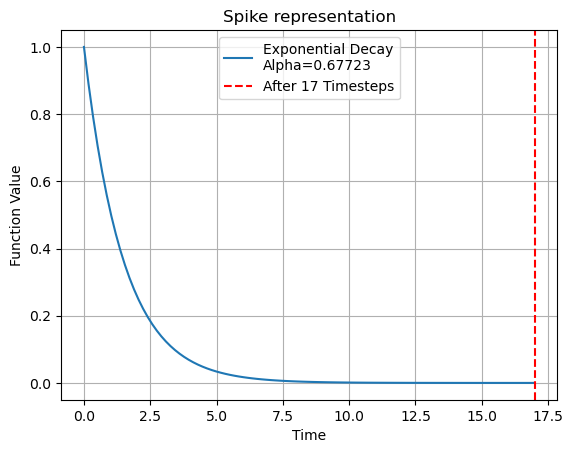

The value after 17 timesteps is: 0.00001


In [22]:
def negative_exponential(t, initial_value, alpha):
    return initial_value * np.exp(-alpha * t)

def compute_alpha(initial_value, threshold, timestep):
    target_value = initial_value * threshold
    alpha = -math.log(target_value) / timestep
    return alpha

initial_value = 1.0
threshold = 0.00001
timesteps = 17

alpha_value = compute_alpha(initial_value, threshold, timesteps)

time_values = np.linspace(0, timesteps, 100)
exponential_values = negative_exponential(time_values, initial_value, alpha_value)

plt.plot(time_values, exponential_values, label=f'Exponential Decay\nAlpha={alpha_value:.5f}')
plt.axvline(x=timesteps, color='r', linestyle='--', label='After 17 Timesteps')
plt.legend()
plt.title('Spike representation')
plt.xlabel('Time')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()

value_after_17_timesteps = negative_exponential(timesteps, initial_value, alpha_value)
print(f'The value after 17 timesteps is: {value_after_17_timesteps:.5f}')


In [23]:
def custom_spikegen_plane(data, alpha_value,num_step=40):

    spike_data = torch.zeros(size=(num_step+16,batch_size,1,ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    
    for n_batch, evt in enumerate(data):
    
        notZeroBx = evt[evt[:,2] > 0][:,2].numpy()
        if len(notZeroBx) == 0:
            break
        
        startTime = min(500,min(notZeroBx))
            
        for hit in evt[evt[:,2] > 0]:
            
            bx = int(hit[2])
            time = int(bx - startTime)
            
            layer = int(hit[0])
            wire = int(hit[1])
            
            x_values = torch.arange(0, 16, dtype=torch.float32)  # Assuming x takes values from 0 to 16
            tensor_result = negative_exponential(x_values,1,alpha_value)
            
            spike_data[time:time+16, n_batch, 0,layer-1, wire-1] = spike_data[time:time+16, n_batch, 0,layer-1, wire-1] + tensor_result
                
                
    return spike_data[0:num_step] 

## Net1

In [109]:
num_epochs = 5
loss_hist = []

net = CNN_spike([100,60],num_inputs,num_hidden,num_outputs,num_steps)
print(net,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(100, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=960, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.19227409362793 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 2.873469114303589 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 2.795116424560547 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 3.5987753868103027 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 4.171950340270996 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.9215970039367676 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 3.168653964996338 

Epoch: 0
Batch: 350
Iter

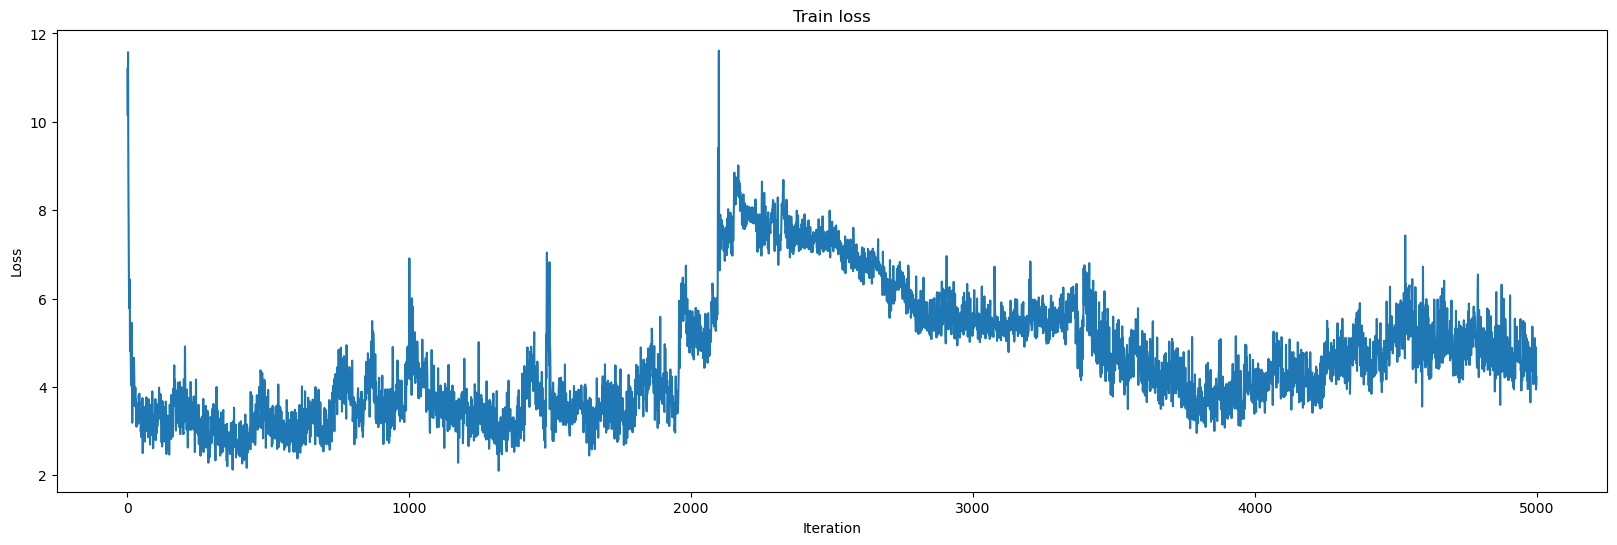

In [110]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [111]:
miss = print_accuracy_spiketrain(net,val_loader)

Total correctly classified events: 5012/10000
Accuracy: 50.12%


## Net2

In [112]:
num_epochs = 5
loss_hist2 = []

net2 = CNN_spike2(100,num_inputs,num_hidden,num_outputs,num_steps)
print(net2,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net2.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net2.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net2(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist2.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike2(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_in): Linear(in_features=1600, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 12.227736473083496 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 1.8345909118652344 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 1.3011722564697266 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 1.0597492456436157 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 1.3332723379135132 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.7998965382575989 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.9048764705657959 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.8388945460319519 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6462604403495789 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.3143504858016968 

Epoch: 0
Batch: 

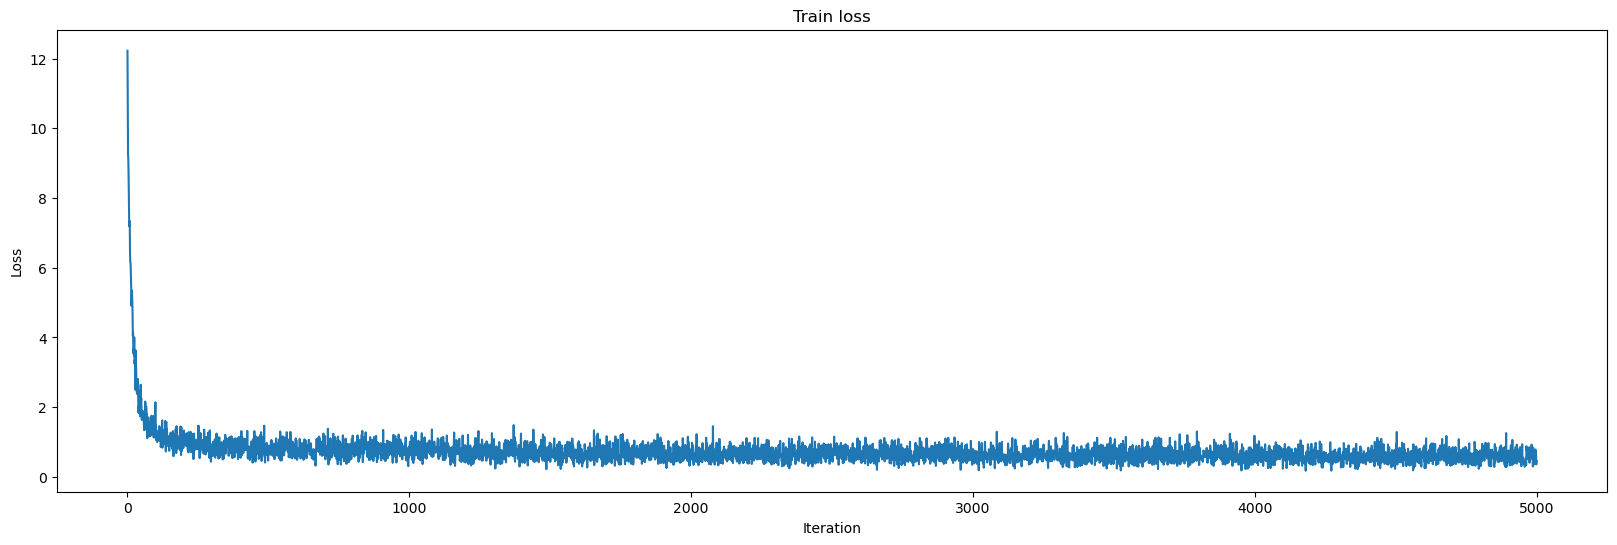

In [113]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist2)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [114]:
miss2 = print_accuracy_spiketrain(net2,val_loader)

Total correctly classified events: 6315/10000
Accuracy: 63.15%


## Net3

In [115]:
num_epochs = 5
loss_hist3 = []

net3 = CNN_spike3(100,num_inputs,num_hidden,num_outputs,num_steps)
print(net3,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net3.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net3.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net3(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist3.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike3(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc_in): Linear(in_features=1600, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 12.799236297607422 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 1.8793667554855347 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 1.3820902109146118 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 1.300466537475586 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 0.6752051711082458 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 0.5185964703559875 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 1.1553088426589966 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.7088093161582947 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.1174439191818237 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.48410916328430176 

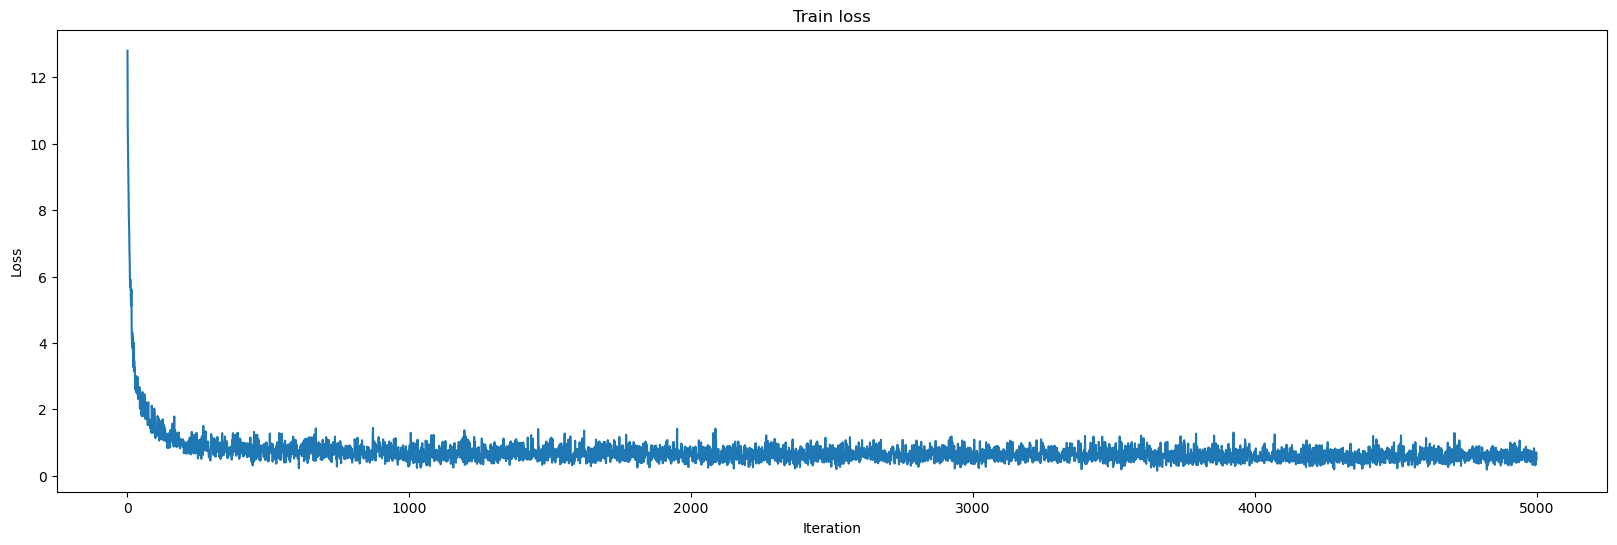

In [116]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist3)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [117]:
miss3 = print_accuracy_spiketrain(net3,val_loader)

Total correctly classified events: 6395/10000
Accuracy: 63.95%


## Net4

In [125]:
num_epochs = 5
loss_hist4 = []

net4 = CNN_spike4(100,num_inputs,num_hidden,num_outputs,num_steps)
print(net4,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net4.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net4.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net4(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist4.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike4(
  (conv1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (fc_in): Linear(in_features=16, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 12.229270935058594 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 7.216339588165283 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 4.016454696655273 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 2.927393674850464 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 1.8817311525344849 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 1.9212037324905396 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.1099770069122314 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.619928002357483 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.7828710079193115 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.0712828636169434 

Epoch: 0

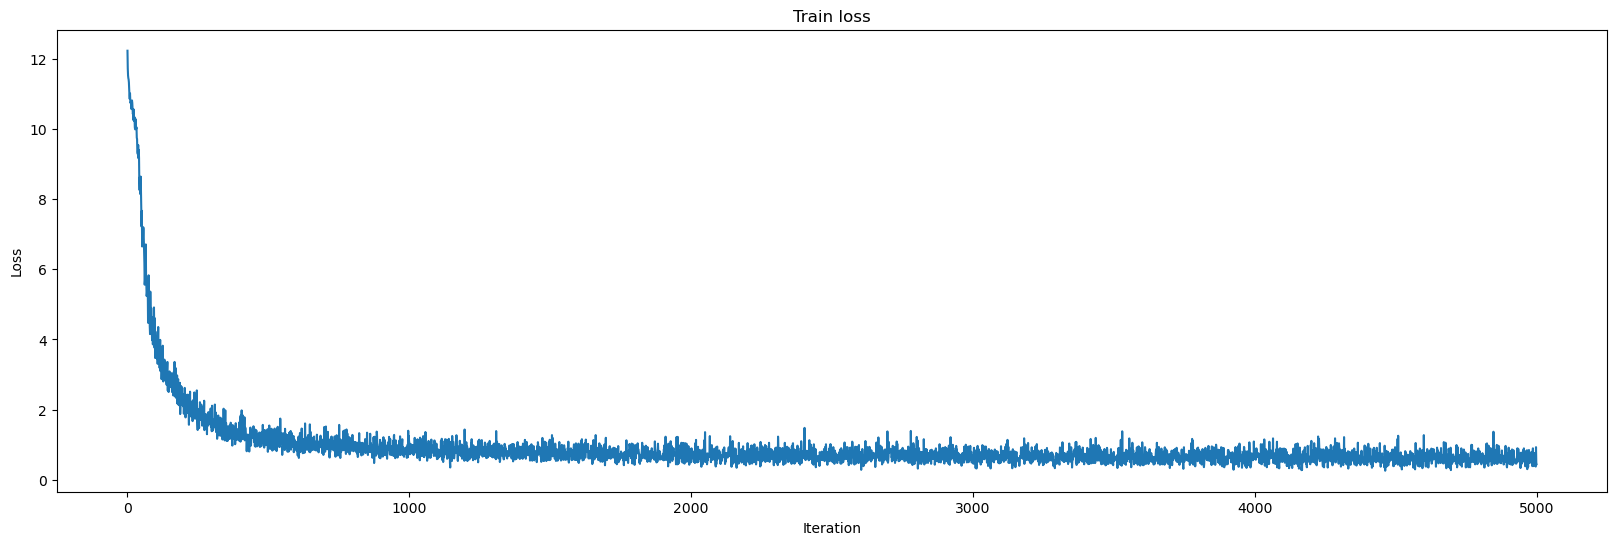

In [126]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist4)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [127]:
miss4 = print_accuracy_spiketrain(net4,val_loader)

Total correctly classified events: 4613/10000
Accuracy: 46.13%


## Net5

In [83]:
num_epochs = 5
loss_hist5 = []

net5 = CNN_spike5(100,num_inputs,num_hidden,num_outputs,num_steps)
print(net5,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net5.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net5.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net5(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist5.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike5(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc_in): Linear(in_features=1600, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 5.664225101470947 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 5.2961554527282715 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 4.472836971282959 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 3.2199759483337402 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.820525646209717 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.193894386291504 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 2.07645320892334 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.4180004596710205 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 1.2164560556411743 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 1.410284161567688 

Epoch: 0
Batch: 550
Iteration: 550
Loss: 1.27015888

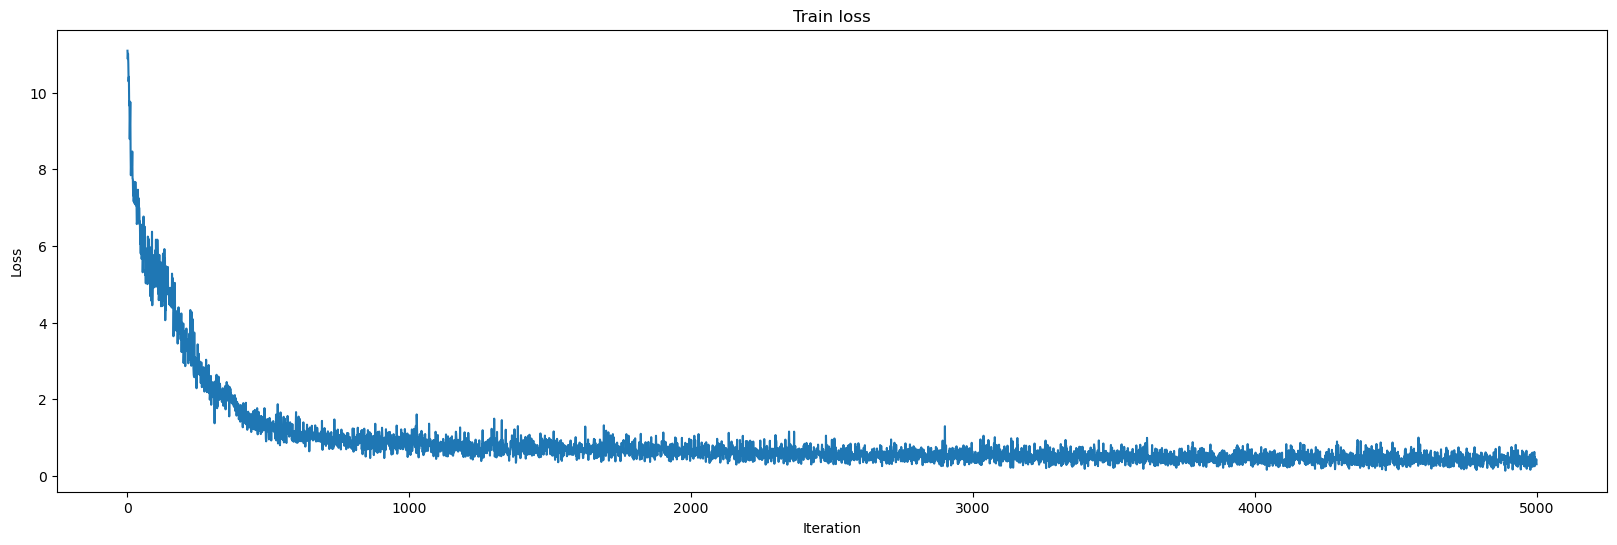

In [84]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist5)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [89]:
miss5 = print_accuracy_spiketrain(net5,val_loader)
miss5 = cell_acc(net5,val_loader)

Total correctly classified events: 9004/10000
Accuracy: 90.04%
Total correctly classified cells: 158580/160000
Accuracy: 99.11%


## Net6

In [91]:
num_epochs = 5
loss_hist6 = []

net6 = CNN_spike6(100,num_inputs,num_hidden,num_outputs,num_steps)
print(net6,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net6.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net6.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net6(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist6.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike6(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(1, 100, kernel_size=(4, 1), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_in): Linear(in_features=400, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.133766174316406 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 6.30128288269043 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 4.351451873779297 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 3.937466621398926 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 2.458953857421875 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.5683324337005615 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 2.1751046180725098 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.6557745933532715 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.615934133529663 

Epoch: 0
Batch: 450
Iterat

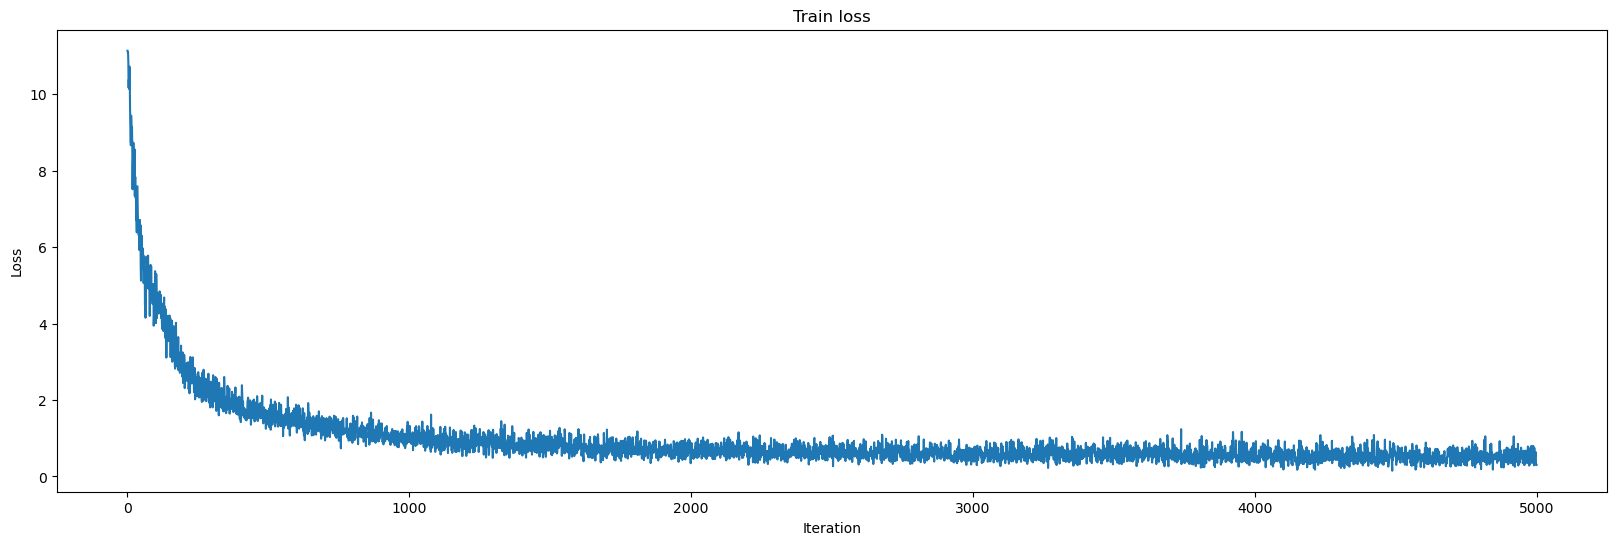

In [92]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist6)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [93]:
miss6 = print_accuracy_spiketrain(net6,val_loader)
miss6 = cell_acc(net6,val_loader)

Total correctly classified events: 8754/10000
Accuracy: 87.54%
Total correctly classified cells: 158267/160000
Accuracy: 98.92%


## Net7

In [94]:
num_epochs = 5
loss_hist7 = []

net7 = CNN_spike7([40,20],num_inputs,num_hidden,num_outputs,num_steps)
print(net7,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net7.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net7.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net7(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist7.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike7(
  (conv1): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv1): Leaky()
  (conv2): Conv2d(40, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv2): Leaky()
  (fc_in): Linear(in_features=320, out_features=100, bias=True)
  (lif_in): Leaky()
  (fc_out): Linear(in_features=100, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 8.442891120910645 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 5.21687126159668 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 4.493009567260742 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 2.0091159343719482 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 1.2428399324417114 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 1.1021558046340942 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.1488478183746338 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 0.6574540734291077 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.73406457

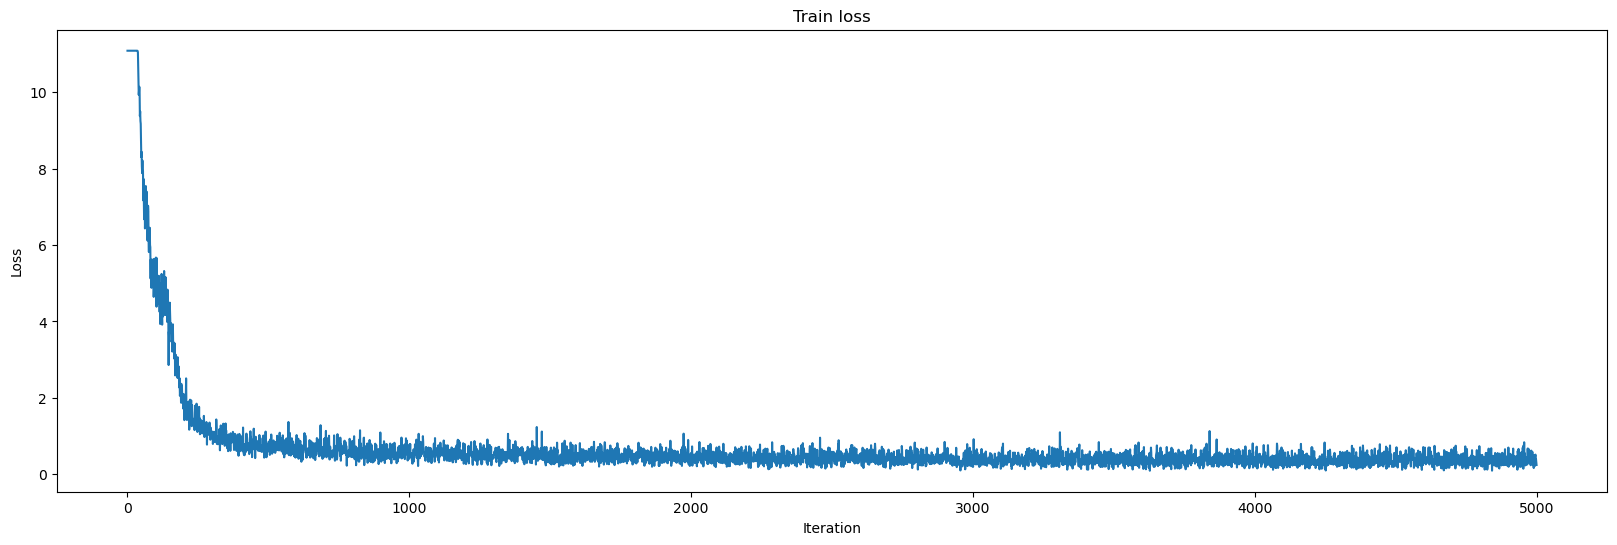

In [95]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist7)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [96]:
miss7 = print_accuracy_spiketrain(net7,val_loader)
miss7 = cell_acc(net7,val_loader)

Total correctly classified events: 9027/10000
Accuracy: 90.27%
Total correctly classified cells: 158509/160000
Accuracy: 99.07%


In [115]:
loss_hist=[]
with torch.no_grad():
    net7.eval()
    
    
    for batch in val_loader:
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        spk_rec, mem_rec = net7(spike_in)
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        loss_hist.append(loss_val)

mean_loss = np.mean(loss_hist)
print('Loss:',mean_loss) 

Loss: 0.38776222


## Net8

In [97]:
num_epochs = 5
loss_hist8 = []

net8 = CNN_spike8([40,16],num_inputs,num_hidden,num_outputs,num_steps)
print(net8,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net8.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net8.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net8(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist8.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike8(
  (conv1): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv1): Leaky()
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv2): Leaky()
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_out): Linear(in_features=256, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 13.915548324584961 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 2.450941562652588 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 1.9324312210083008 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 1.2345364093780518 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 1.3550970554351807 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 1.4328622817993164 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 0.8324859738349915 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 0.9228062629699707 

Epoch: 0
Batch: 

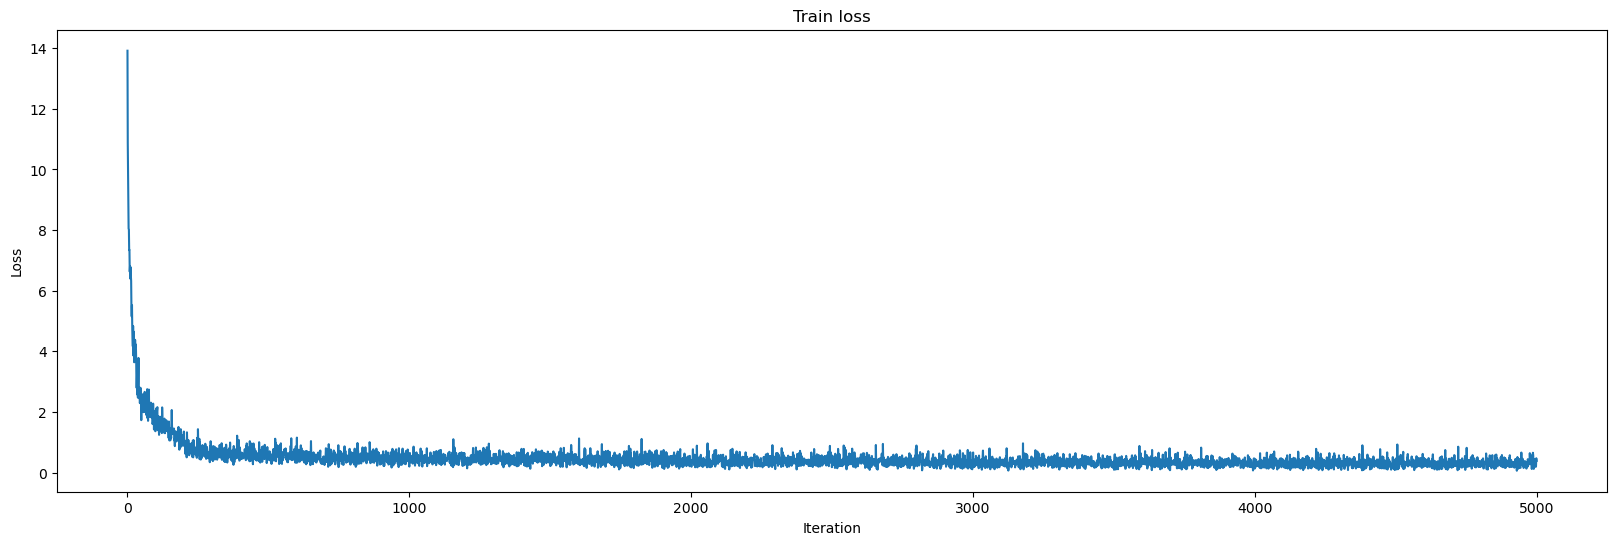

In [98]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist8)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [99]:
miss8 = print_accuracy_spiketrain(net8,val_loader)
miss8 = cell_acc(net8,val_loader)

Total correctly classified events: 7609/10000
Accuracy: 76.09%
Total correctly classified cells: 156113/160000
Accuracy: 97.57%


## Net9

In [100]:
num_epochs = 5
loss_hist9 = []

net9 = CNN_spike9([40,16],num_inputs,num_hidden,num_outputs,num_steps)
print(net9,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net9.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net9.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net9(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist9.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike9(
  (conv1): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv1): Leaky()
  (conv2): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv2): Leaky()
  (fc_out): Linear(in_features=256, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 5.458530426025391 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 4.822292327880859 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 3.316148281097412 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 1.5635579824447632 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 1.1813253164291382 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 1.0235865116119385 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.2883875370025635 

Epoch: 0
Batch: 400
Iteration: 400
Loss: 1.0238583087921143 

Epoch: 0
Batch: 450
Iteration: 450
Loss: 0.6750884056091309 

Epoch: 0
Batch: 500
Iteration: 500
Loss: 0.6511677503585815 

Epoch: 0
B

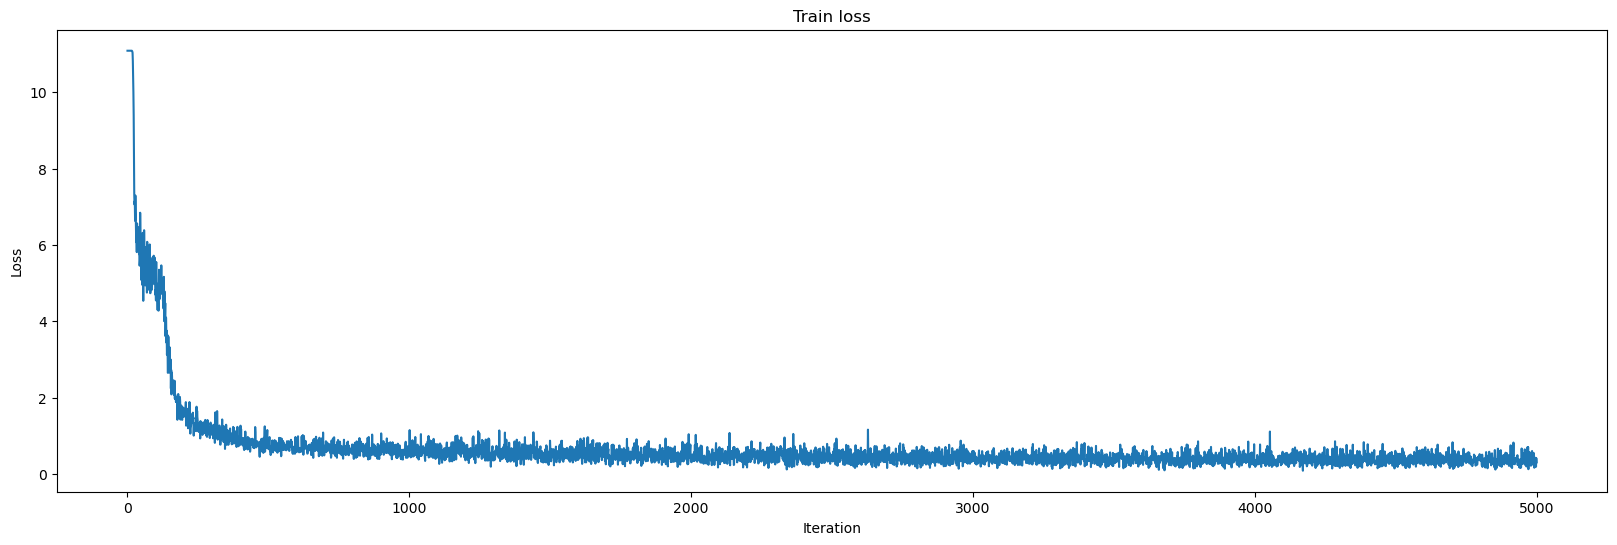

In [101]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist9)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [102]:
miss9 = print_accuracy_spiketrain(net9,val_loader)
miss9 = cell_acc(net9,val_loader)

Total correctly classified events: 9147/10000
Accuracy: 91.47%
Total correctly classified cells: 158785/160000
Accuracy: 99.24%


In [114]:
loss_hist=[]
with torch.no_grad():
    net9.eval()
    
    
    for batch in val_loader:
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        spk_rec, mem_rec = net9(spike_in)
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        loss_hist.append(loss_val)

mean_loss = np.mean(loss_hist)
print('Loss:',mean_loss) 

Loss: 0.3628899


## Net10

In [66]:
num_epochs = 5
loss_hist10 = []

net10 = CNN_spike10([100,40,16],num_inputs,num_hidden,num_outputs,num_steps)
print(net10,'\n')
print('Start training:\n')
# Define the loss function and optimizer
criterion = Multi_loss(2, SF.ce_count_loss())
optimizer = torch.optim.Adam(net10.parameters(), lr=5e-4, betas=(0.9, 0.999))

iter_counter = 0
# Training loop using DataLoader
for epoch in range(num_epochs):
    batch_counter = 0
    for batch in train_loader:
        
        net10.train()
        
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        # forward pass
        spk_rec, mem_rec = net10(spike_in)
        
        # Compute the loss
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist10.append(loss_val.item())
        
        if iter_counter % 50 == 0:
            print("Epoch:",epoch)
            print("Batch:",batch_counter)
            print("Iteration:",iter_counter)
            print("Loss:",loss_val.item(),"\n")
            
            
        batch_counter += 1
        iter_counter += 1

CNN_spike10(
  (conv1): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv1): Leaky()
  (conv2): Conv2d(100, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv2): Leaky()
  (conv3): Conv2d(40, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif_conv3): Leaky()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_out): Linear(in_features=64, out_features=32, bias=True)
  (lif_out): Leaky()
) 

Start training:

Epoch: 0
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 0
Batch: 50
Iteration: 50
Loss: 7.768744945526123 

Epoch: 0
Batch: 100
Iteration: 100
Loss: 6.280237197875977 

Epoch: 0
Batch: 150
Iteration: 150
Loss: 4.25765323638916 

Epoch: 0
Batch: 200
Iteration: 200
Loss: 2.3190081119537354 

Epoch: 0
Batch: 250
Iteration: 250
Loss: 2.1496846675872803 

Epoch: 0
Batch: 300
Iteration: 300
Loss: 1.9080586433410645 

Epoch: 0
Batch: 350
Iteration: 350
Loss: 1.528930902481079 

Epoch: 0

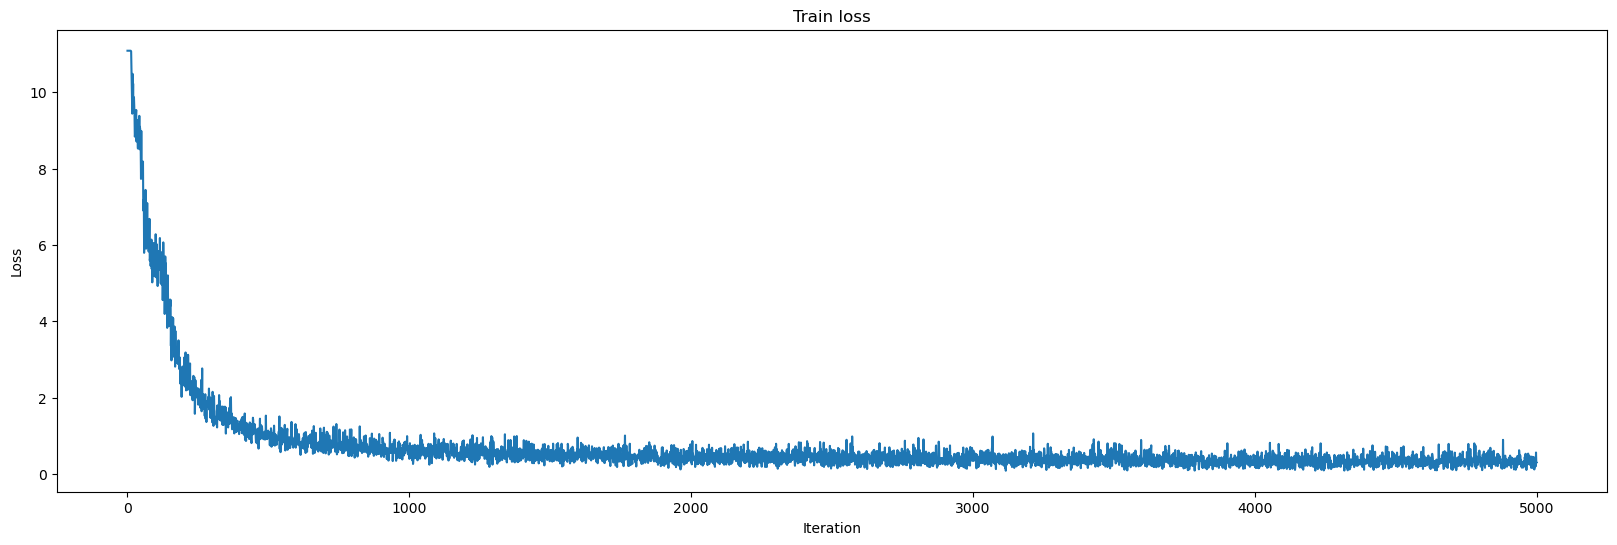

In [67]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(loss_hist10)
plt.title("Train loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
#plt.yscale("log")
plt.show()

In [71]:
miss10 = print_accuracy_spiketrain(net10,val_loader)
miss10 = cell_acc(net10,val_loader)

Total correctly classified events: 9253/10000
Accuracy: 92.53%
Total correctly classified events: 158958/160000
Accuracy: 99.35%


In [72]:
loss_hist=[]
with torch.no_grad():
    net10.eval()
    
    
    for batch in val_loader:
        data_it = batch['data']
        targets = batch['label'].squeeze().type(torch.LongTensor)
        inputs = batch['window']
        
        spike_in = custom_spikegen_plane(data_it,alpha_value,num_steps)
        
        spk_rec, mem_rec = net10(spike_in)
        loss_val = criterion(spk_rec, targets.view(batch_size, -1))
        loss_hist.append(loss_val)

mean_loss = np.mean(loss_hist)
print('Loss:',mean_loss) 

Loss: 0.30118832
